In [1]:
!pip install pandas_datareader
!pip install --upgrade pandas

In [2]:
import pandas as pd
import datetime as dt
from pandas_datareader import data
import mplfinance as mpf

#apikey = '取得したAPIキー'
apikey = 'KDDTQTNE9OTMD4V4.'
symbol = 'EURUSD'

start = dt.date(2005,1,1)
end = dt.date(2020,12,30)

df = data.DataReader(symbol,'av-daily',start,end, api_key=apikey)

In [3]:
df['volume']=0.1 

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

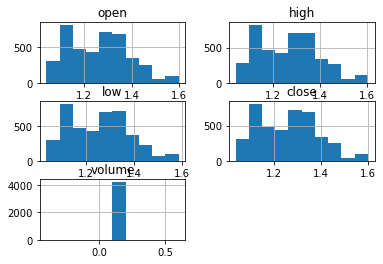

In [4]:
df.hist()

In [5]:
import numpy
#df = df.apply(numpy.log)
#from scipy.stats import boxcox
#df2,_ = boxcox(df['close'])

In [6]:
#df=df.assign(open=df2,high=df2,low=df2,close=df2)

In [7]:
#df.hist()

In [8]:
wsize=50 #サンプル期間
after=5 #最終レコード＋α
change_large = 2 #変化大　4%

In [9]:
df.index = pd.DatetimeIndex(df.index)

alldata =[]

for time in range(len(df)-wsize-1):
    try:
        dfspan = df[time:time+wsize]
        dflast = df.at[df.index[time+wsize], 'close']
        dfafter = df.at[df.index[time+wsize+after], 'close']
        changerate=(dfafter-dflast)/dflast*100#変化率
    
        if changerate>0:
            if changerate>change_large:
                dflabel="++"
#            elif changerate>change_small:
#                dflabel="+"
            else:
                dflabel="0"
        else:
            if changerate*-1>change_large:
                dflabel="--"
#            elif changerate*-1>change_small:
#                dflabel="-"
            else:
                dflabel="0"
        alldata.append({"df":dfspan,"label":dflabel})
    except:
        pass

In [11]:
import os
# Path to the train folder
new_dir_path = './train/'
for i in ['--','0','++']:
    os.mkdir(new_dir_path+i)

In [12]:
import tqdm
import matplotlib as mpl

sma_s= 20
sma_m= 25

cs  = mpf.make_mpf_style(base_mpl_style='dark_background',gridcolor="#000000",mavcolors=['#00ff00','#0000ff'], facecolor="#000000")

for i in tqdm.tqdm(range(len(alldata))):
    mpf.plot(alldata[i]['df'],savefig= new_dir_path + alldata[i]['label']+ '/'\
             + str(i) + 'test.png',mav=(sma_s,sma_m),figsize=(2.5,2.5), type='line',\
             figratio=(12,4),style=cs,axisoff=True,\
             linecolor='#ff0000',tight_layout=True)


100%|█████████████████████████████████████████████| 4118/4118 [05:40<00:00, 12.10it/s]


In [13]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [14]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

#画像データをImageFolderを使って取込みする
#mean=[0.485, 0.456, 0.406]
#std=[0.229, 0.224, 0.225]
mean = (0.5,)
std = (0.5,)
images = ImageFolder( new_dir_path, transform = ImageTransform(mean, std))
images.class_to_idx

{'++': 0, '--': 1, '0': 2}

In [15]:
import torch.utils.data as data

#1バッチに含む画像の枚数を指定する
batch_size = 64

#ImageFolderで取り込んだ画像からデータローダーを作成する
train_dataloader = data.DataLoader(images, batch_size = batch_size, shuffle = True)

In [16]:
#データローダから、画像とラベルのテンソルを取り出す。
imgs, labels = iter(train_dataloader).next()

#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",imgs[0].shape)

image shape ==>; torch.Size([3, 224, 224])


Label is  2


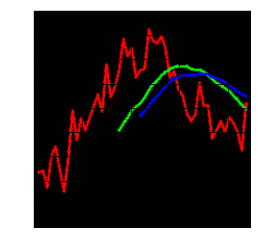

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("Label is ",labels[0].numpy())

Label is  2


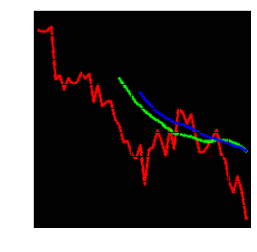

In [18]:
#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(imgs[63])
plt.imshow(pic)
print("Label is ",labels[63].numpy())

In [19]:
# 学習データ、検証データに 8:2 の割合で分割する。
train_size = int(0.8 * len(images))
val_size = len(images) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    images, [train_size, val_size]
)

In [20]:
#1バッチに含む画像の枚数を指定する
batch_size = 20

#ImageFolderで取り込んだ画像からデータローダーを作成する
dataloaders = {
  'train': data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
  'valid': data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(val_dataset)
}

In [21]:
from torchvision import models, transforms
import torch.nn as nn
vgg16 = models.vgg16(pretrained=True)

# 全結合層の変更(最終層の出力を2にする)
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 3),
)

In [22]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# 出力層の変更
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_ftrs,  out_features=3)

net_ft1 = vgg16.to(device)

# 損失関数および学習パラメーターの定義
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_ft1.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 訓練モードに設定
net_ft1.train()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
num_epochs = 20
acc_history_ft1 = {'train': [], 'valid': []}

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            net_ft1.train()
        else:
            net_ft1.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net_ft1(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        acc_history_ft1[phase].append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 0/19
----------
train Loss: 0.4360 Acc: 0.8904
valid Loss: 0.4086 Acc: 0.8847
Epoch 1/19
----------
train Loss: 0.3759 Acc: 0.8925
valid Loss: 0.3900 Acc: 0.8847
Epoch 2/19
----------
train Loss: 0.3280 Acc: 0.8937
valid Loss: 0.4061 Acc: 0.8847
Epoch 3/19
----------
train Loss: 0.2745 Acc: 0.9065
valid Loss: 0.3666 Acc: 0.8835
Epoch 4/19
----------
train Loss: 0.2418 Acc: 0.9117
valid Loss: 0.4355 Acc: 0.8871
Epoch 5/19
----------
train Loss: 0.2014 Acc: 0.9211
valid Loss: 0.3998 Acc: 0.8714
Epoch 6/19
----------
train Loss: 0.1731 Acc: 0.9296
valid Loss: 0.3751 Acc: 0.8799
Epoch 7/19
----------
train Loss: 0.1049 Acc: 0.9587
valid Loss: 0.4077 Acc: 0.8786
Epoch 8/19
----------
train Loss: 0.0827 Acc: 0.9666
valid Loss: 0.4401 Acc: 0.8799
Epoch 9/19
----------
train Loss: 0.0680 Acc: 0.9742
valid Loss: 0.4643 Acc: 0.8799
Epoch 10/19
----------
train Loss: 0.0583 Acc: 0.9763
valid Loss: 0.4724 Acc: 0.8835
Epoch 11/19
----------
train Loss: 0.0540 Acc: 0.9839
valid Loss: 0.5134 Ac

(0.0, 1.0)

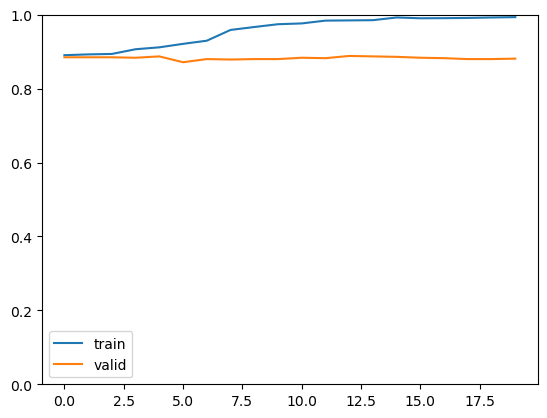

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')


fig = plt.figure()
ax = fig.add_subplot()
ax.plot([a.cpu().numpy() for a in acc_history_ft1['train']], label='train')
ax.plot([a.cpu().numpy() for a in acc_history_ft1['valid']],label='valid')
ax.legend()
ax.set_ylim(0, 1)

In [25]:
torch.save(net_ft1.state_dict(), 'model_state.pth')